## Todo
- need some sort of transformation to make the camera dead center on the playing feild
    - get the OG map take the pixel distance between 2 blocks
    - transform the cam upwards till the pixel distances match (or are close enough)
    - right angles maybe?
- Get black objects
- Get Traps
- Get deposit
- get pixel locations of a objects
    - make the blobs into single points (**New approach use findcontours and approximate to a square**)
        - optimize it for less execution time and make it actually catch everything
    - discard whats outside map boundry (**Where is the boundry**)
    - get pixel locations of points

In [35]:
%matplotlib inline

import cv2
import time
import PIL.Image
import numpy as np
import IPython.display
from pprint import pprint
import matplotlib.pyplot as plt

a=cv2.VideoCapture("good.webm")
ret,frame=a.read()

def showarray(a, fmt='png'):
    IPython.display.display(PIL.Image.fromarray(a))

In [86]:
#even though it says BGR treat it like RBG [r,g,b]
upp_blue_Hsv=cv2.cvtColor(np.uint8([[[0,0,255]]]),cv2.COLOR_BGR2HSV).reshape(3,)
low_blue_Hsv=cv2.cvtColor(np.uint8([[[0,0,60]]]),cv2.COLOR_BGR2HSV).reshape(3,)

In [81]:
upp_blue_Hsv

array([  0, 255, 255], dtype=uint8)

In [90]:
low_blue_Hsv[1]=60 # sets saturation

In [94]:
upp_blue_Hsv[1]=60

In [36]:
def get_color(frame,up,low):
    '''get_color(frame,[0,0,255],[0,0,30]) get Blue objects'''
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #even though it says BGR treat it like RBG [r,g,b]
    upp_blue_Hsv=cv2.cvtColor(np.uint8([[up]]),cv2.COLOR_BGR2HSV).reshape(3,)
    low_blue_Hsv=cv2.cvtColor(np.uint8([[low]]),cv2.COLOR_BGR2HSV).reshape(3,)
    low_blue_Hsv[1]=60 # sets saturation

    mask = cv2.inRange(hsv, low_blue_Hsv, upp_blue_Hsv)

    res = cv2.bitwise_and(frame,frame,mask= mask) #apply mask
    return res,mask

In [40]:
res,mask=get_color(frame,[0,0,255],[0,0,30])
im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

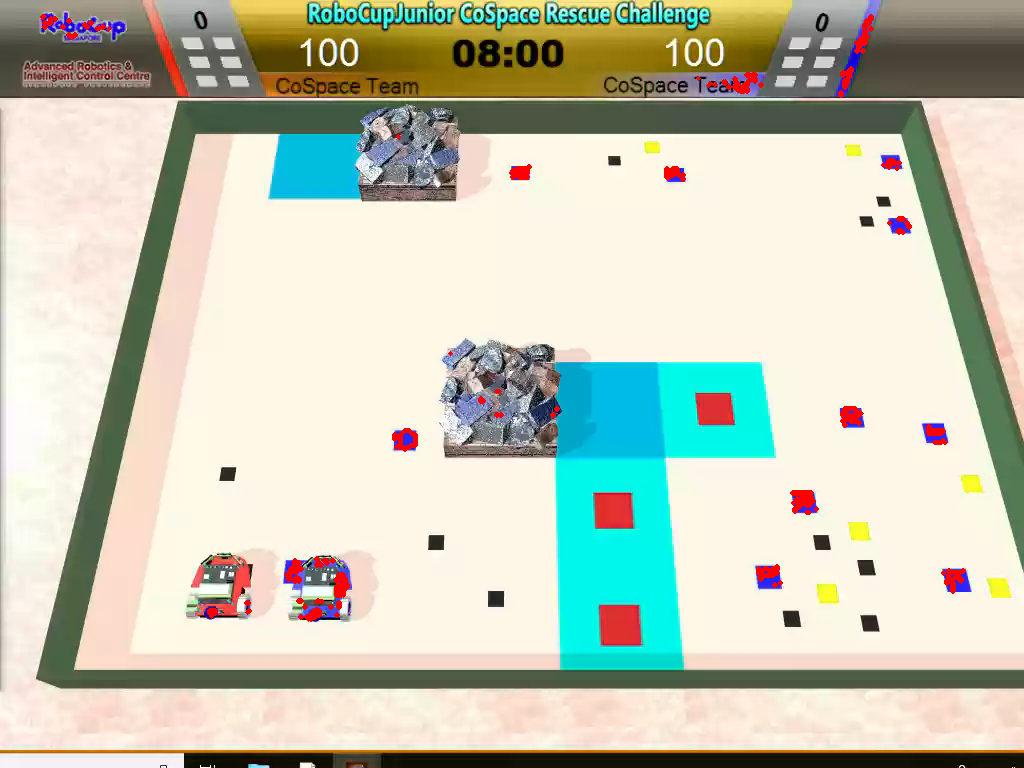

In [48]:
fc=frame.copy()
showarray(cv2.drawContours(fc, contours, -1, (255,0,0), 3))

In [38]:
def npwhere_toxyztupels(x,y,z):
    '''from np.where inices to x,y,z coordinates in the image'''
    
    if not (len(x)==len(y)==len(z)):
        raise ValueError("xyz MUST BE len(x)==len(y)==len(z)")
        
    r_tupels=[(x[i],y[i],z[i]) for i in range(len(x))]
    return r_tupels

(28, 2)
0.0733549594879


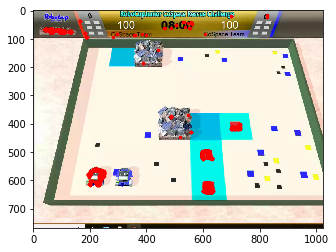

In [53]:
'''Get Pixel coordinates'''
b=get_color(frame,[255,0,0],[30,0,0])[0]
x,y,z = np.where(b>0) # see https://stackoverflow.com/questions/33747908/
tar=npwhere_toxyztupels(x,y,z)

cord_ar=list(tar)#np.array(tar)
cord_ar_new=[]
cord_ar =np.delete(np.array(cord_ar),2,1)
t=time.time()
'''This sucks maybe 2 points are close but arent next to eachother'''
'''Plus slow for loop'''
for i in range(0,len(cord_ar)-1):
    a_b=np.array(cord_ar[i])-np.array(cord_ar[i+1])
    if not (np.linalg.norm(a_b)<100): #eculidan distance metric exclude if more that 100pixels of distance
        cord_ar_new.append(cord_ar[i])
cord_ar_new=np.array(cord_ar_new)
print(cord_ar_new.shape)
print(time.time()-t)

#the np.flip is because numpy and matplotlib treat axis def.
''' **REMOVE IN PROD np.flip** '''
cord_ar_new_viz=np.flip(cord_ar) # remove the color thing  at the last indice
implot = plt.imshow((frame))
plt.scatter(cord_ar_new_viz[:,0],cord_ar_new_viz[:,1], c='r', s=5)
plt.show()

In [12]:
cord_ar=np.array(tar)
cord_ar_new=[]
cord_ar =np.delete(np.array(cord_ar),2,1)
#dist = np.sqrt(((cord_ar[:, None] - np.roll(cord_ar[:,None]) ) ** 2))
#dist = np.sqrt(((a[:, None] - b[:, :, None]) ** 2).sum(0))

p1=cord_ar
p2=np.roll(cord_ar,0)
dist = np.sqrt(((p1[:,None] - p2[:,:, None]) ** 2).sum(0))



#dist = np.sqrt((p2[None,:]-p1[None,:] + (p2[:,None]-p1[:,None]) )

In [213]:
np.roll(cord_ar,2)

array([[619, 311],
       [ 16,  42],
       [ 16,  42],
       ...,
       [619, 310],
       [619, 311],
       [619, 311]])

In [207]:
cord_ar.tolist()

[[16, 42],
 [16, 42],
 [16, 42],
 [16, 43],
 [16, 43],
 [16, 43],
 [16, 44],
 [16, 44],
 [16, 870],
 [16, 870],
 [16, 870],
 [16, 871],
 [16, 871],
 [16, 871],
 [17, 42],
 [17, 42],
 [17, 42],
 [17, 43],
 [17, 43],
 [17, 43],
 [17, 870],
 [17, 870],
 [17, 870],
 [17, 871],
 [17, 871],
 [17, 871],
 [18, 50],
 [18, 50],
 [18, 50],
 [18, 51],
 [18, 51],
 [18, 51],
 [18, 54],
 [18, 54],
 [18, 54],
 [18, 55],
 [18, 55],
 [18, 55],
 [18, 870],
 [18, 870],
 [18, 870],
 [18, 871],
 [18, 871],
 [18, 871],
 [19, 50],
 [19, 50],
 [19, 50],
 [19, 51],
 [19, 51],
 [19, 51],
 [19, 54],
 [19, 54],
 [19, 54],
 [19, 55],
 [19, 55],
 [19, 55],
 [19, 870],
 [19, 870],
 [19, 870],
 [19, 871],
 [19, 871],
 [19, 871],
 [20, 68],
 [20, 68],
 [20, 68],
 [20, 69],
 [20, 69],
 [20, 69],
 [20, 866],
 [20, 866],
 [20, 866],
 [20, 867],
 [20, 867],
 [20, 867],
 [21, 68],
 [21, 68],
 [21, 68],
 [21, 69],
 [21, 69],
 [21, 69],
 [21, 866],
 [21, 866],
 [21, 866],
 [21, 867],
 [21, 867],
 [21, 867],
 [22, 44],
 [22, 4

In [13]:
dist.tolist()

[[0.0, 31808.322260062694], [31808.322260062694, 0.0]]

In [ ]:

cord_ar_new=np.delete(cord_ar, np.argwhere(np.ediff1d(cord_ar) <= 10) + 1)#.tolist()
print(cord_ar_new.shape)
print(time.time()-t)

#the np.flip is because numpy and matplotlib treat axis def.
''' **REMOVE IN PROD np.flip** '''
cord_ar_new_viz=np.flip(cord_ar_new) # remove the color thing  at the last indice
implot = plt.imshow((frame))
plt.scatter(cord_ar_new_viz[:,0],cord_ar_new_viz[:,1], c='r', s=5)
plt.show()

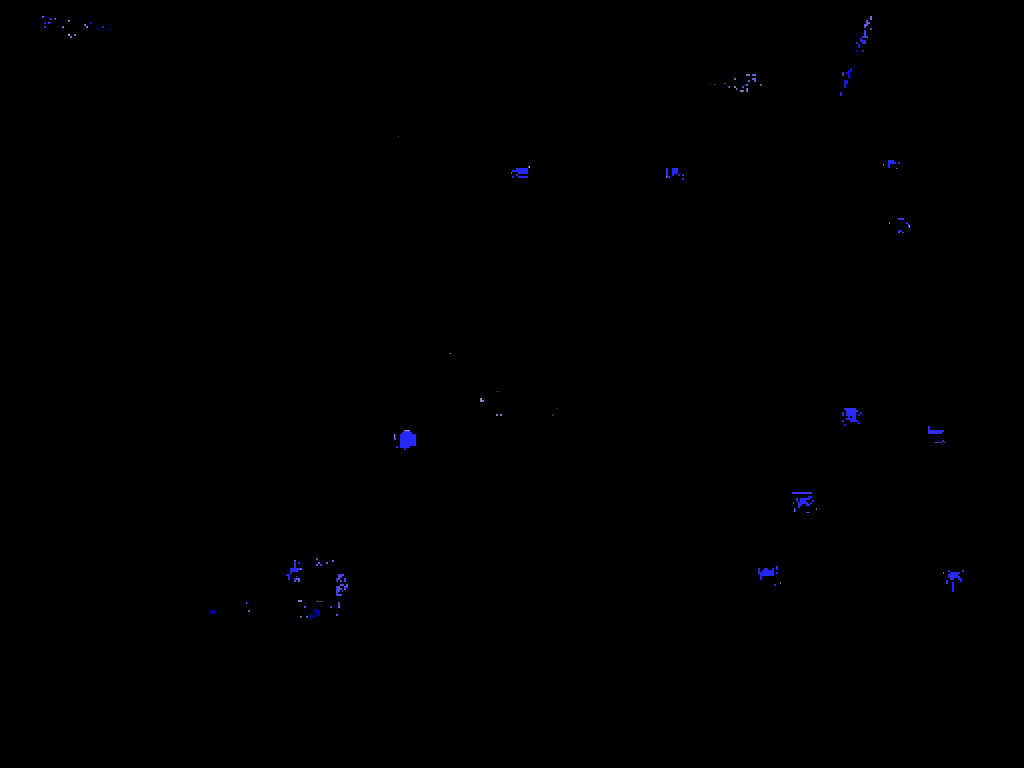

In [179]:
'''Get Blue Robot and Blue Objects'''
showarray(get_color(frame,[0,0,255],[0,0,30]))

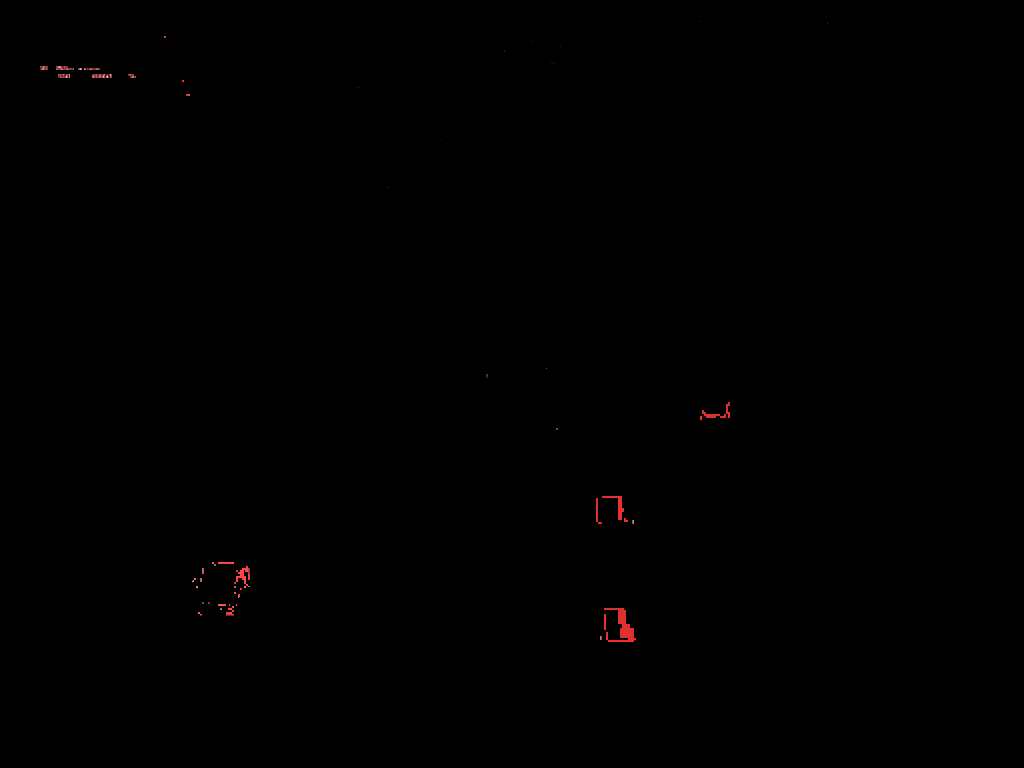

In [177]:
'''Get red Robot and red Objects'''
showarray(get_color(frame,[255,0,0],[30,0,0]))

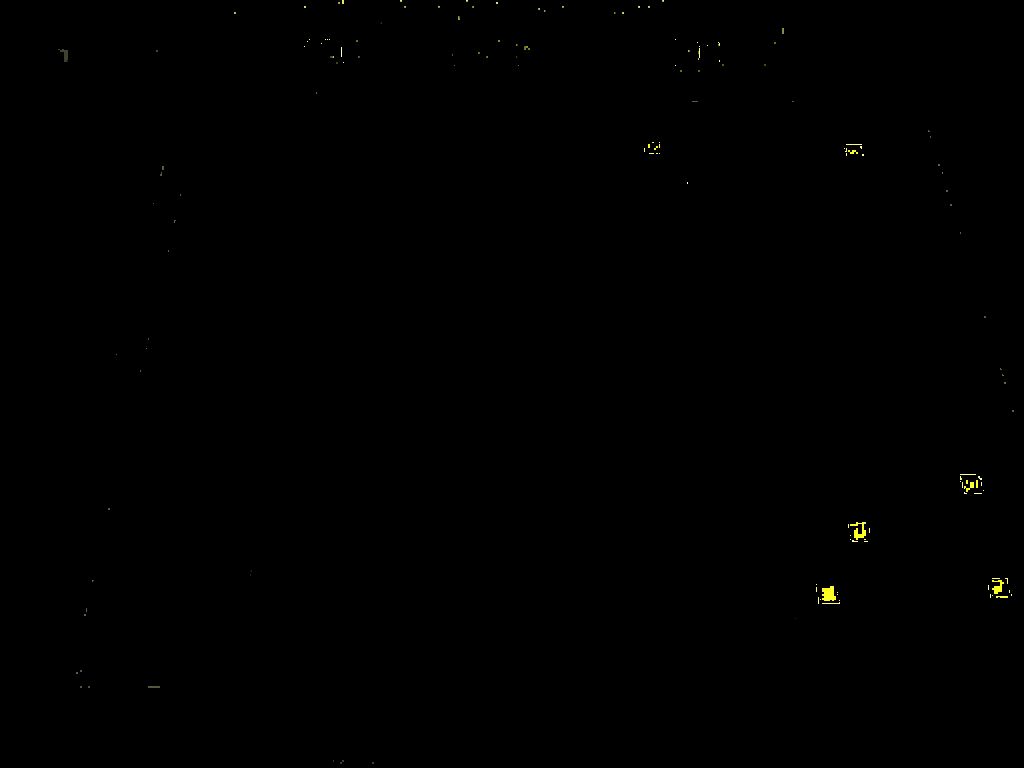

In [178]:
'''Get yellow Objects'''
showarray(get_color(frame,[255,255,0],[30,30,0]))

[0 0 0]


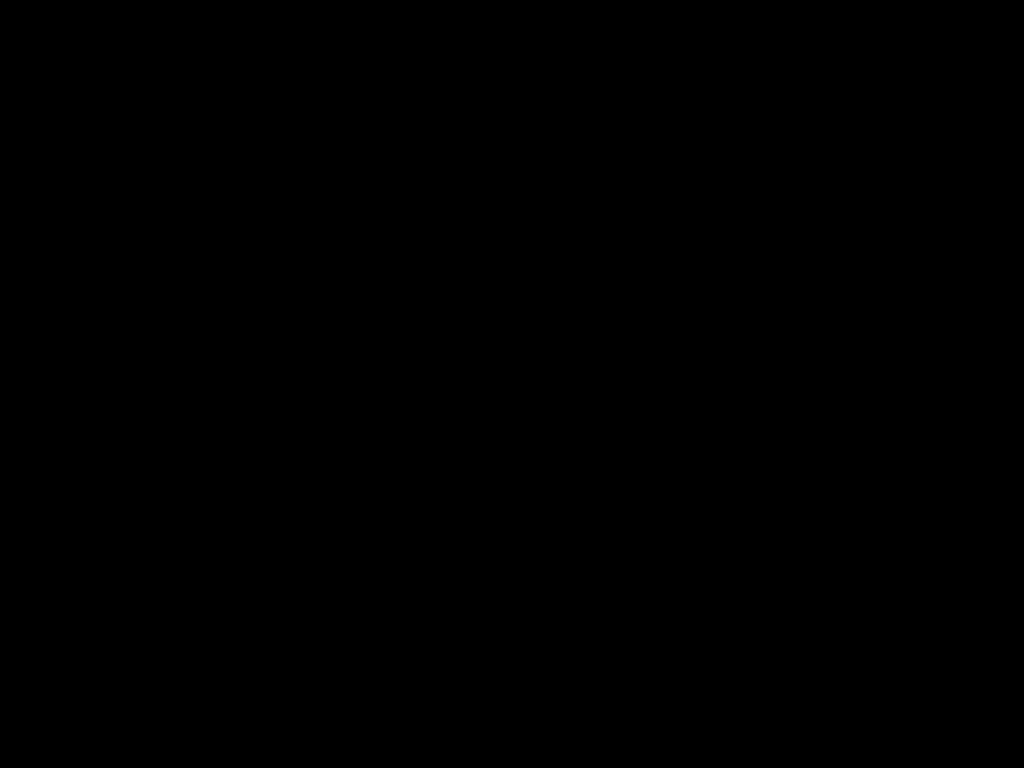

In [167]:
'''Get black Objects'''
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#even though it says BGR treat it like RBG [r,g,b]
upp_blue_Hsv=cv2.cvtColor(np.uint8([[[50,50,50]]]),cv2.COLOR_BGR2HSV).reshape(3,)
low_blue_Hsv=cv2.cvtColor(np.uint8([[[0,0,0]]]),cv2.COLOR_BGR2HSV).reshape(3,)
print(low_blue_Hsv)
low_blue_Hsv[1]=60 # sets saturation
#upp_blue_Hsv[1]=60

mask = cv2.inRange(hsv, low_blue_Hsv, upp_blue_Hsv)

res = cv2.bitwise_and(frame,frame,mask= mask) #apply mask
showarray(mask)

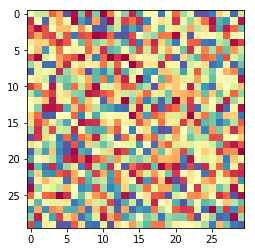

In [29]:
%matplotlib inline
from pylab import imshow, show, get_cmap
from numpy import random

Z = random.random((30, 30))   # Test data

imshow(Z, cmap=get_cmap("Spectral"), interpolation='nearest')
show()

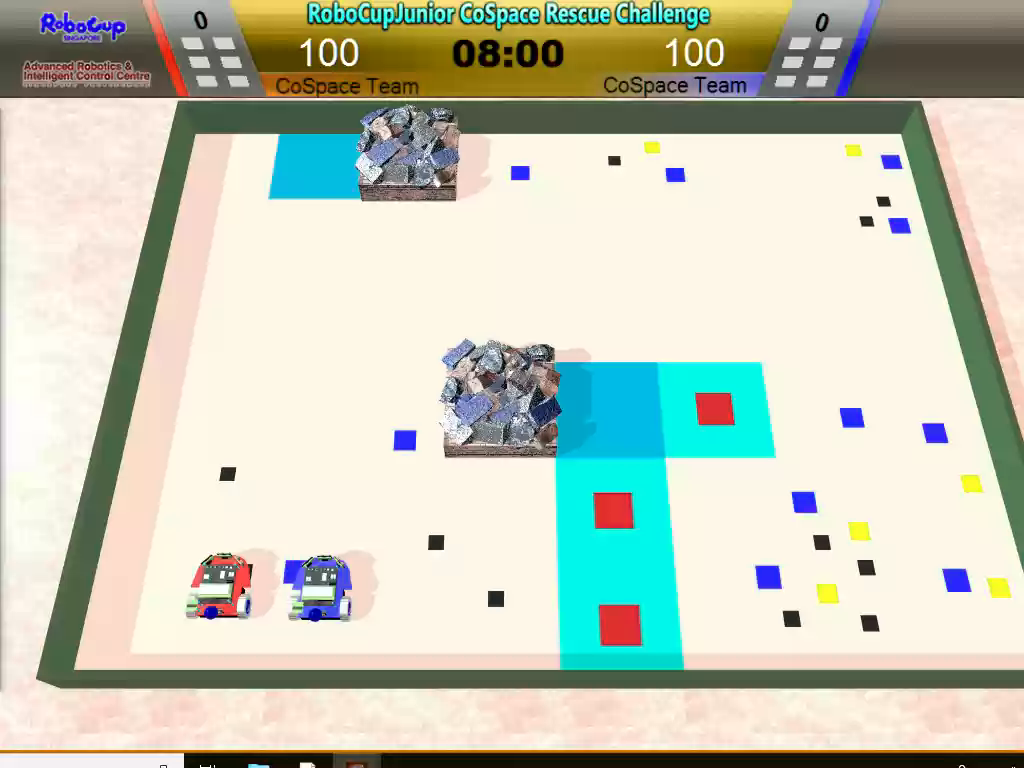

In [18]:
showarray(frame)